In [1]:
from rdkit import Chem, RDConfig

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

from dataProcessing import *

### loading the preprocessed data

In [3]:
rf_dict = np.load('rf.npy',allow_pickle=True).item()

X_train = pd.read_csv('train.csv')
X_val = pd.read_csv('val.csv')
X_test = pd.read_csv('test.csv')

### scaling the data

In [4]:
data_scaler = DataScaler(categorical_column='measurement_type', label='measurement_value',scale_by_group=False)
X_train = data_scaler.fit_transform(X_train)
X_val = data_scaler.transform(X_val)
X_test = data_scaler.transform(X_test)


In [5]:

class convert_df_fea(DataPreprocessor):
    def __init__(self, rf_dict,X_train):
        super().__init__(X_train)
        self.rf_dict = rf_dict
        
    def transform(self, X):
        X = super().transform(X)
        X['mf'] = X['SMILES'].map(self.rf_dict)      
        a = np.array([arr.tolist() for arr in X['mf'].values])
        b = np.array([arr.tolist() for arr in X['measurement_type'].values])
        c = np.array([arr.tolist() for arr in X['Kinase_name'].values])
        X_transformed = np.column_stack((a,b,c))
        y_transformed = X['measurement_value']
        return X_transformed, y_transformed

### converting features to model input format

In [7]:
data_preprocessor = convert_df_fea(rf_dict,X_train)
X_train,y_train = data_preprocessor.transform(X_train)
X_val, y_val = data_preprocessor.transform(X_val)
X_test , y_test= data_preprocessor.transform(X_test)

### model fit and predictions

In [9]:
model = RandomForestRegressor(n_estimators=50,random_state=42,n_jobs=32,verbose=1)
model.fit(X_train, y_train)

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:  2.3min remaining:   44.3s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:  2.4min finished


RandomForestRegressor(n_estimators=50, n_jobs=32, random_state=42, verbose=1)

In [10]:
# Make predictions on the test and validation sets
y_pred_test = model.predict(X_test)
y_pred_val = model.predict(X_val)

# Calculate the MAE for the test and validation sets
mae_test = mean_absolute_error(y_test, y_pred_test)
mae_val = mean_absolute_error(y_val, y_pred_val)

print("MAE on test set:", mae_test)
print("MAE on validation set:", mae_val)

MAE on test set: 0.0640985185482452
MAE on validation set: 0.06585801751027767


[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done  38 out of  50 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=32)]: Done  50 out of  50 | elapsed:    0.0s finished


### error and accuracy analysis

In [97]:
X_val = pd.read_csv('val.csv')
X_test = pd.read_csv('test.csv')
testit=pd.concat((X_test,X_val))

In [101]:
testit['preds']=np.concatenate((y_pred_test,y_pred_val))
testit = data_scaler.inverse_transform(testit,'preds')

## mae for total test+val after inverse transfom and Accuracy

In [106]:
from utils import *

In [107]:
get_accuracy_mae(testit)

unscaled mae: 0.39051693735498844
Accuracy of pKi :  0.7806122448979592
Accuracy of pIC50 :  0.8194662480376766


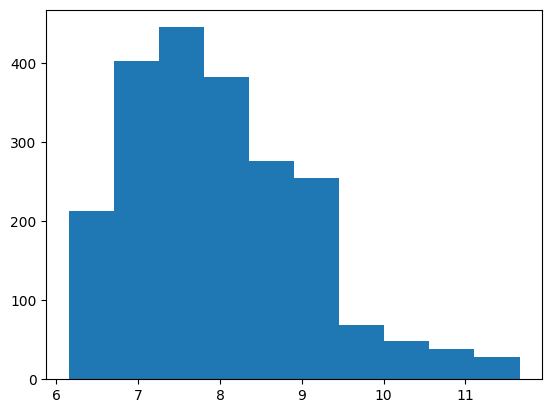

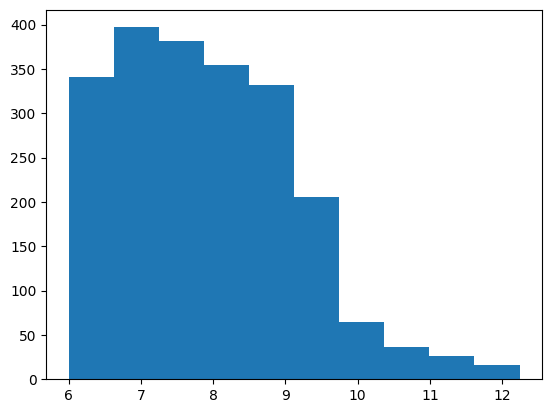

In [120]:
#Check Normality of residuals
plt.hist(testit['preds'])
plt.show()
plt.hist(testit['measurement_value'])
plt.show()

## molecules with big prediction difference

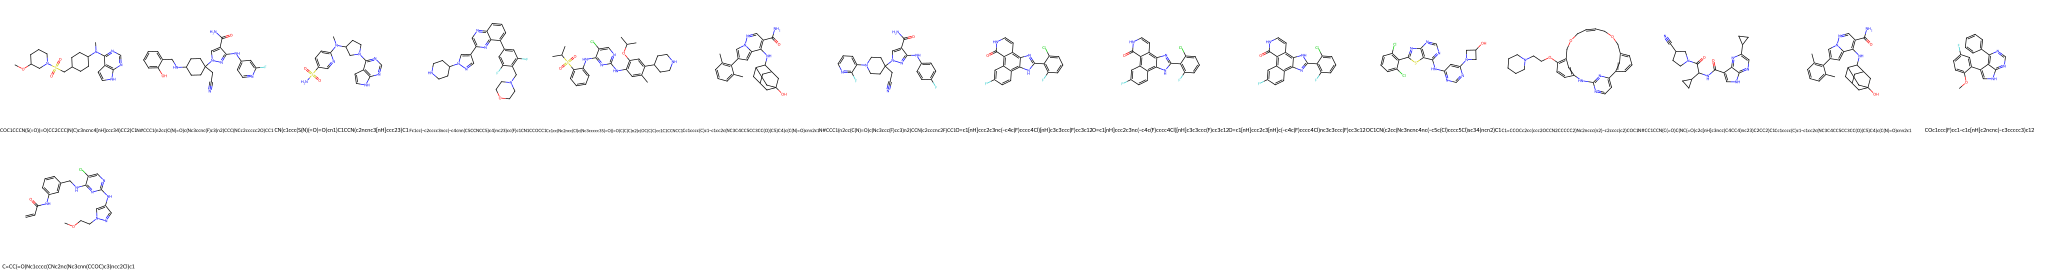

In [121]:


import matplotlib.pyplot as plt
from rdkit.Chem import Draw
# generate a list of "smile" molecules
smiles = testit[testit['abs']>1.8].SMILES.values
molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(molecules, molsPerRow=15, useSVG=True,subImgSize=(400, 400), legends=list(smiles))

## molecules with small prediction difference

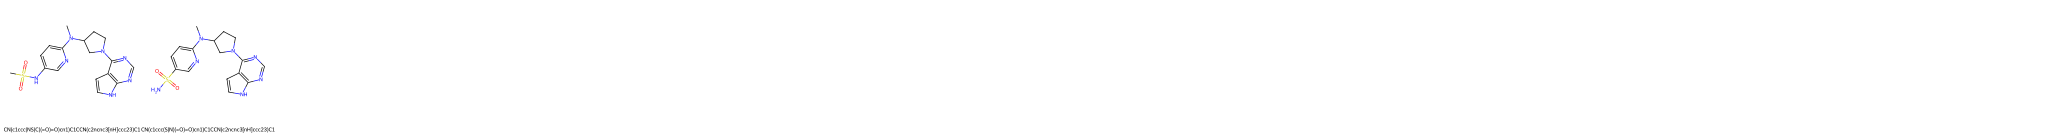

In [123]:

# generate a list of "smile" molecules
smiles = testit[testit['abs']<0.001].SMILES.values

molecules = [Chem.MolFromSmiles(smile) for smile in smiles]

Draw.MolsToGridImage(molecules, molsPerRow=15, useSVG=True,subImgSize=(400, 400), legends=list(smiles))